<a href="https://colab.research.google.com/github/vit050587/neural_networks/blob/master/KVA_INN_HW_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 8. GAN

* Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети
* Сделайте краткий обзор научной работы, посвящённой алгоритму нейронных сетей, не рассматриваемому ранее на курсе. Проведите анализ: чем отличается выбранная архитектура от других? В чём плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при её применении на практике?

# 1. Знакомство с данными

Для финального проекта выбран набор данных по флюорографии (рентген лёгких): https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

Датасет содержит:

* изображения рентгеновских снимков (80 здоровых и 58 с туберкулёзом),
маски,
* текстовые описания к каждому объекту (пол, возраст и дагноз):

Формат изображений: PNG, 4020x4892 или 4892x4020, 12 бит.

# Загрузка необходимых библиотек и функций

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import PIL
import re
from tqdm import tqdm
from glob import glob
from collections import defaultdict
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import plot_model

import keras
import keras.backend as K
from keras import backend as keras

import cv2

### U-net 
from keras.models import Sequential, Model, model_from_json, load_model
from keras.layers import (Input, Dense, Dropout, Activation, Flatten, Convolution2D, 
                          MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate)
from keras.layers.convolutional import Conv2D
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.activations import *

In [9]:
def test_on_image(model, img_array, img_num, img_side_size = 128):
    
    pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    fig = plt.figure(figsize = (15,10))
    
    plt.subplot(1,4,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("Predict")
    plt.axis("off")
    
    plt.subplot(1,4,2)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("Real mask");
    plt.axis("off")
    
    plt.subplot(1,4,3)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
    plt.title("Overlay")
    plt.axis("off")
    
    plt.subplot(1,4,4)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap = "gray")
    plt.title("Original")
    plt.axis("off")
    
    return pred

# dice коэффициент
# функции нужно писать не на Numpy, а на бекэнде, на котором запущен keras, в данном случае на TensorFlow
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

def dice_coef_test(y_true, y_pred):
    # 
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [10]:
# построение графиков лосса и дайс коэффицента вв процессе обучения
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross Entropy")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Dice coefficient")

# Загрузка, обработка и визуализация данных

In [11]:
DIR = "/content/drive/MyDrive/Colab Notebooks/neural_networks/lesson08/Lung Segmentation"

lung_image_paths = glob(os.path.join(DIR,"CXR_png/*.png"))
mask_image_paths = glob(os.path.join(DIR,"masks/*.png"))

related_paths = defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)

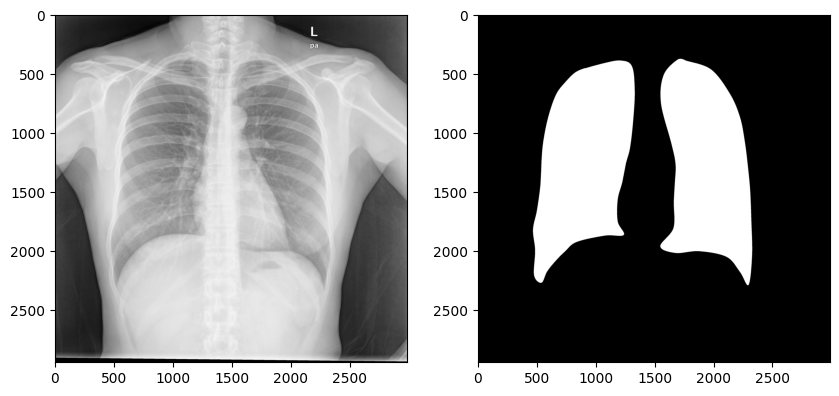

In [12]:
xray_num = 1
img_path = paths_df["image_path"][xray_num]
mask_path = paths_df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray");

# Предобработка данных

In [13]:
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)
  
    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (256,256), color_mode = "gray")

100%|██████████| 26/26 [00:07<00:00,  3.55it/s]


In [14]:
# разбиваем на трейн и тест
img_train, img_test, mask_train, mask_test = train_test_split(img_array, 
                                                              mask_array, 
                                                              test_size = 0.2, 
                                                              random_state= 42)
img_side_size = 256
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size, 1)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size, 1)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size, 1)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size, 1)

# 3. Эксперименты с моделями

Для начала возмём нейронную сеть Unet с курса обучения

In [15]:
def u_net(input_shape=(256, 256, 1)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # в Unet основной посыл в том, чтобы прокидывать признаки в конец сетки,
    # когда уже идёт предсказание маски. Поэтому мы запоминаем этот слой и прокидываем его в конец
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)


    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # начинаем растягивать картинку
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # конкатенируем то что получили после 3-го увеличения и блок 3
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор (14 классов, поэтому softmax)
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    return model

In [16]:
model_1 = u_net(input_shape=(256,256,1))
model_1.compile(optimizer=Adam(),
              loss="binary_crossentropy",
              metrics=[dice_coef, 'binary_accuracy'])
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

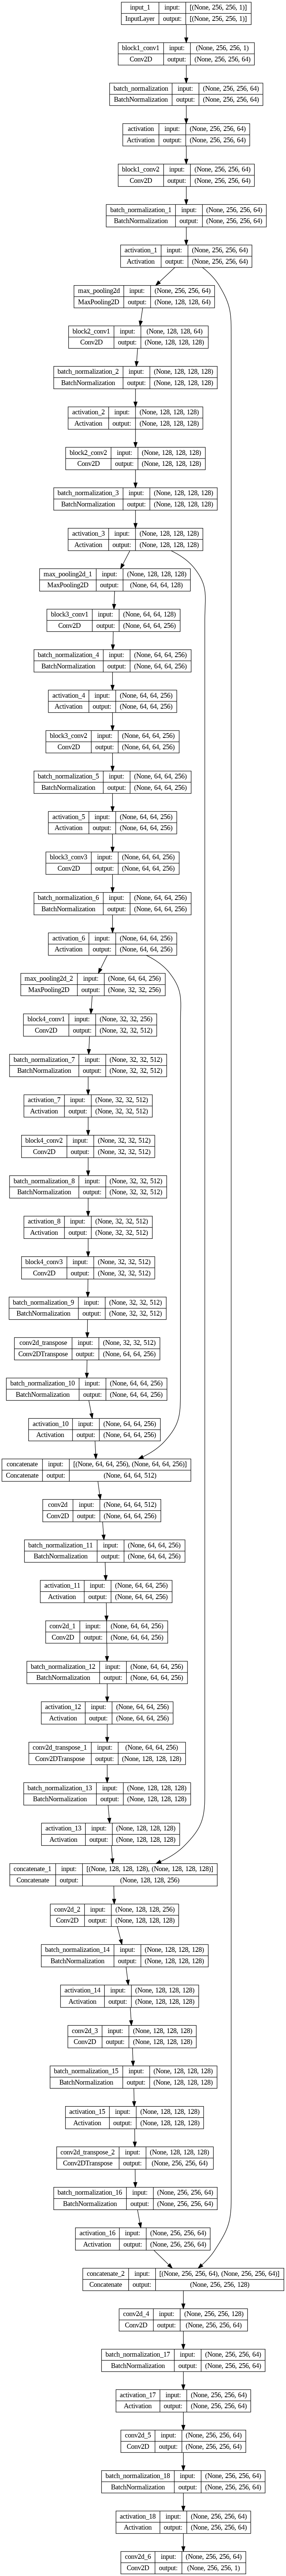

In [17]:
plot_model(model_1, to_file='model_1.png', show_shapes=True)

In [19]:
earlystopping = EarlyStopping(monitor='loss', patience=10)
history_1 = model_1.fit(x = img_train, 
                    y = mask_train, 
                    validation_data = (img_test, mask_test), 
                    epochs = 5, #30
                    batch_size = 16,
                    callbacks = [earlystopping])

Epoch 1/5
2/2 [==============================] - 93s 27s/step - loss: 0.6151 - dice_coef: 0.4961 - binary_accuracy: 0.6781 - val_loss: 0.6613 - val_dice_coef: 0.3371 - val_binary_accuracy: 0.7048
Epoch 2/5
2/2 [==============================] - 91s 27s/step - loss: 0.4032 - dice_coef: 0.5614 - binary_accuracy: 0.8313 - val_loss: 0.6609 - val_dice_coef: 0.3372 - val_binary_accuracy: 0.6966
Epoch 3/5
2/2 [==============================] - 91s 27s/step - loss: 0.3685 - dice_coef: 0.5726 - binary_accuracy: 0.8679 - val_loss: 0.6557 - val_dice_coef: 0.3387 - val_binary_accuracy: 0.6954
Epoch 4/5
2/2 [==============================] - 91s 26s/step - loss: 0.2720 - dice_coef: 0.7016 - binary_accuracy: 0.9202 - val_loss: 0.6896 - val_dice_coef: 0.3542 - val_binary_accuracy: 0.5310
Epoch 5/5
2/2 [==============================] - 94s 27s/step - loss: 0.2330 - dice_coef: 0.6990 - binary_accuracy: 0.9299 - val_loss: 3.7140 - val_dice_coef: 0.4139 - val_binary_accuracy: 0.3432


# Качество модели

1/1 [==============================] - 2s 2s/step


0.4688808251183095

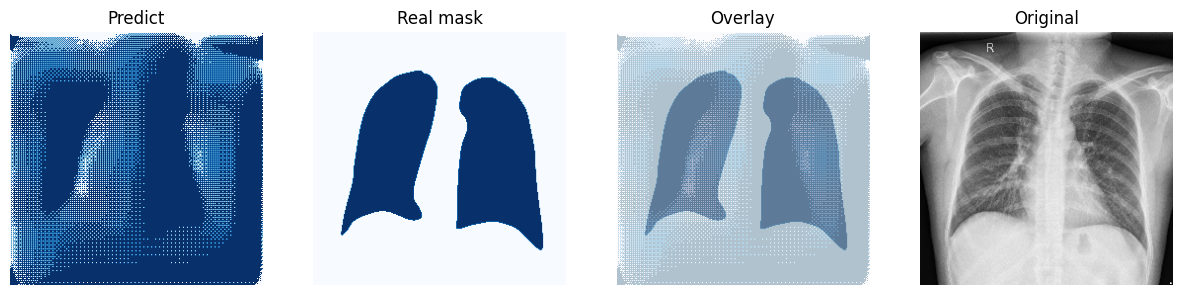

In [20]:
img_num = 1 
prediction_1 = test_on_image(model_1, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_1)

1/1 [==============================] - 2s 2s/step


0.435484460912384

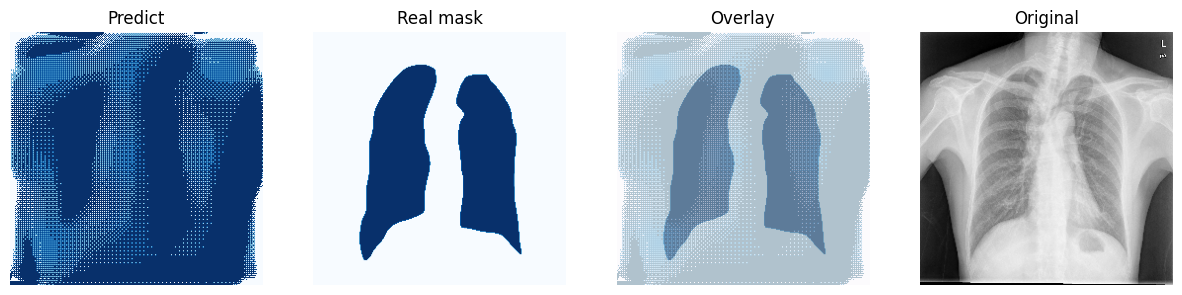

In [21]:
img_num = 3 
prediction_1 = test_on_image(model_1, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_1)

1/1 [==============================] - 1s 1s/step


0.3805439869211565

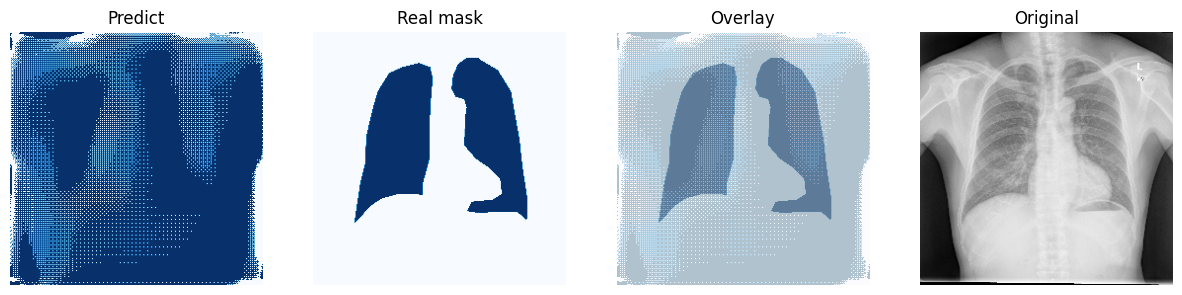

In [22]:
img_num = 5 
prediction_1 = test_on_image(model_1, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_1)

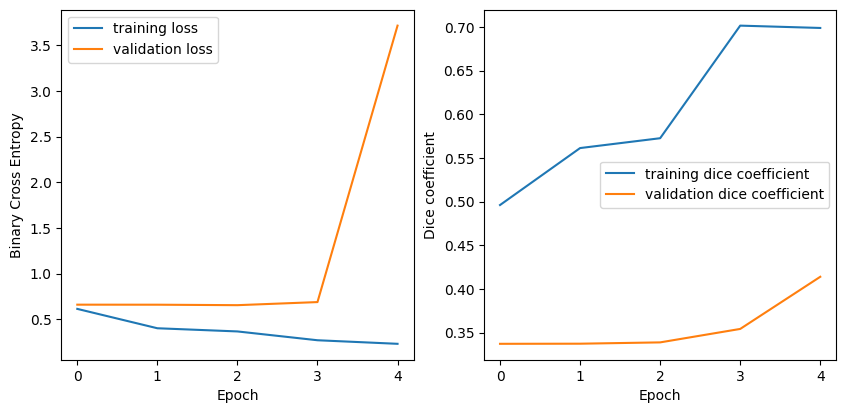

In [23]:
get_metrics(history = history_1)

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


 17%|█▋        | 1/6 [00:01<00:06,  1.33s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 2/6 [00:02<00:05,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████     | 3/6 [00:04<00:04,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 4/6 [00:05<00:02,  1.28s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 5/6 [00:06<00:01,  1.21s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

0.40649336278060727


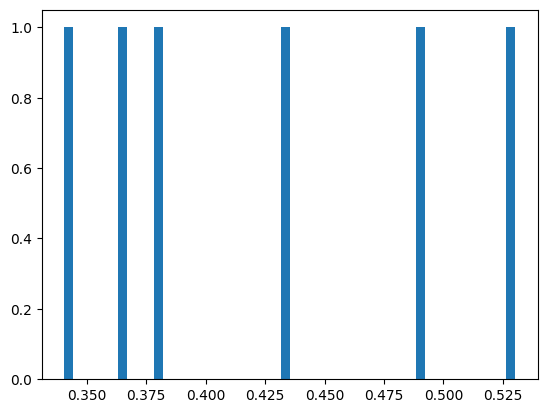

In [24]:
dice_coefs = list()
for i in tqdm(range(len(img_test))):
    prediction_2 = model_1.predict(img_test[i].reshape(1,img_side_size,256,1))
    dice = dice_coef_test(y_true = mask_test[i], y_pred = prediction_1)
    dice_coefs.append(dice)

plt.hist(np.array(dice_coefs), bins = 50)
print(np.median(np.array(dice_coefs)))

**Вывод**: Качество модели удовлетворительное. Медиана дайс-коэффициента равна 0,4064. модель неплохо сегментирует лёгкие.

Попробуем улучшить модель, используя другую архитектуру Unet, найденную на просторах интернета.

In [25]:
### U-net 

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
   
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [26]:
model_2 = unet(input_size=(256,256,1))
model_2.compile(optimizer=Adam(),
              loss="binary_crossentropy",
              metrics=[dice_coef, 'binary_accuracy'])
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 256, 256, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d_7[0][0]']               
                                )                                                           

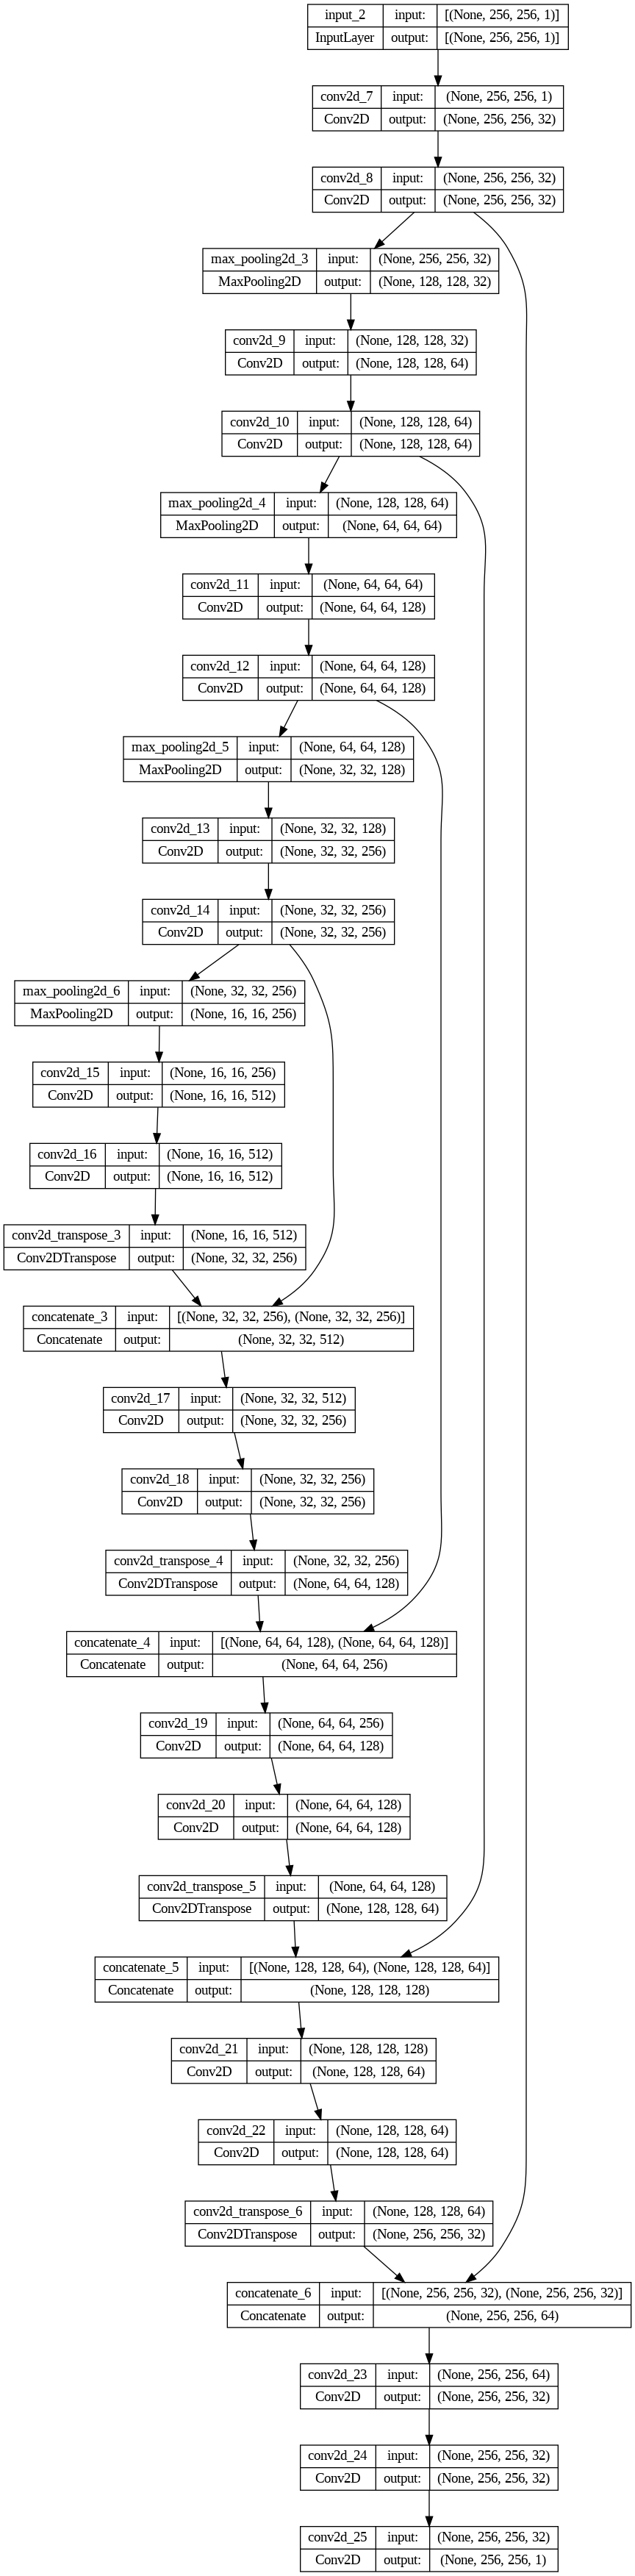

In [27]:
plot_model(model_2, to_file='model_2.png', show_shapes=True)

In [29]:
earlystopping = EarlyStopping(monitor='loss', patience=10)
history_2 = model_2.fit(x = img_train, 
                    y = mask_train, 
                    validation_data = (img_test, mask_test), 
                    epochs = 5, #30
                    batch_size = 16,
                    callbacks = [earlystopping])

Epoch 1/5
2/2 [==============================] - 29s 7s/step - loss: 0.5710 - dice_coef: 0.2263 - binary_accuracy: 0.7761 - val_loss: 0.5988 - val_dice_coef: 0.2444 - val_binary_accuracy: 0.7343
Epoch 2/5
2/2 [==============================] - 29s 8s/step - loss: 0.5420 - dice_coef: 0.2338 - binary_accuracy: 0.7761 - val_loss: 0.5889 - val_dice_coef: 0.2609 - val_binary_accuracy: 0.7343
Epoch 3/5
2/2 [==============================] - 30s 9s/step - loss: 0.5389 - dice_coef: 0.2426 - binary_accuracy: 0.7761 - val_loss: 0.5894 - val_dice_coef: 0.2551 - val_binary_accuracy: 0.7343
Epoch 4/5
2/2 [==============================] - 29s 8s/step - loss: 0.5367 - dice_coef: 0.2261 - binary_accuracy: 0.7761 - val_loss: 0.5921 - val_dice_coef: 0.2464 - val_binary_accuracy: 0.7343
Epoch 5/5
2/2 [==============================] - 29s 8s/step - loss: 0.5358 - dice_coef: 0.2246 - binary_accuracy: 0.7761 - val_loss: 0.5908 - val_dice_coef: 0.2449 - val_binary_accuracy: 0.7343


# 4. Валидация модели

1/1 [==============================] - 1s 527ms/step


0.0

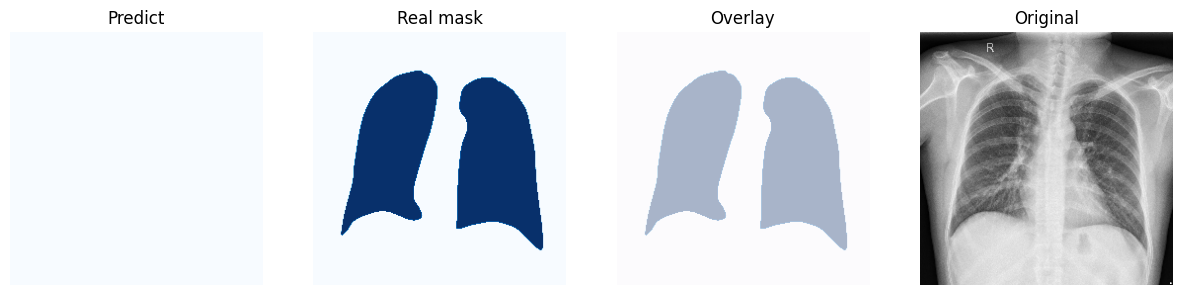

In [30]:
img_num = 1 
prediction_2 = test_on_image(model_2, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_2)

1/1 [==============================] - 1s 512ms/step


0.0

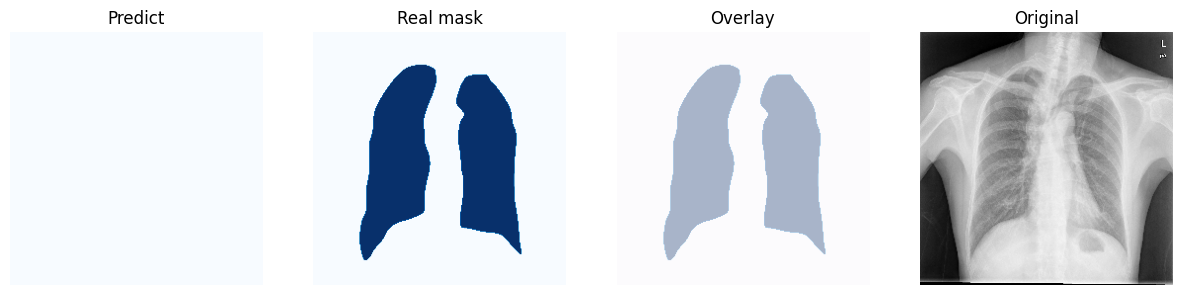

In [31]:
img_num = 3
prediction_2 = test_on_image(model_2, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_2)

1/1 [==============================] - 1s 553ms/step


0.0

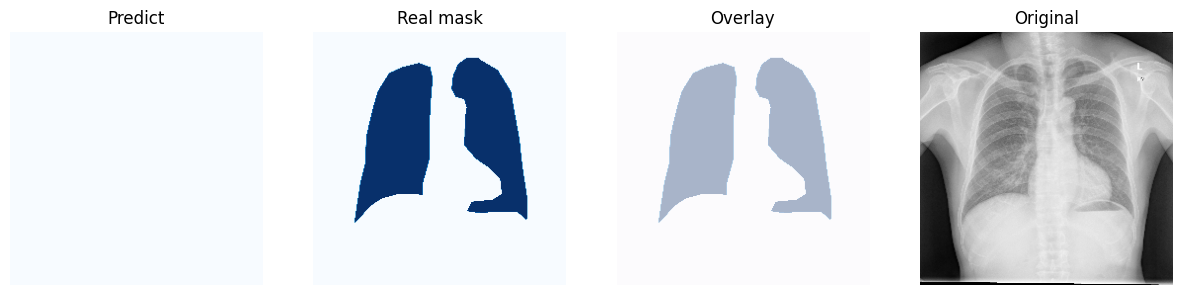

In [32]:
img_num = 5 
prediction_2 = test_on_image(model_2, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_2)

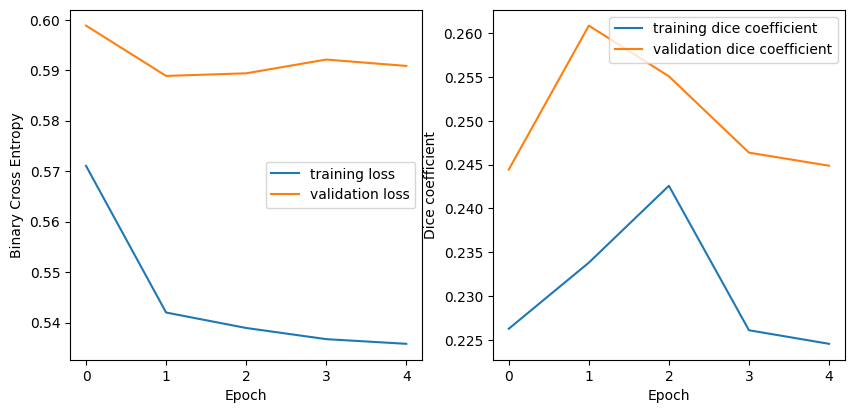

In [33]:
get_metrics(history = history_2)

Распределение Дайс коэффициентов

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 0s 393ms/step


 17%|█▋        | 1/6 [00:00<00:02,  2.32it/s]

1/1 [==============================] - 0s 470ms/step


 33%|███▎      | 2/6 [00:00<00:01,  2.06it/s]

1/1 [==============================] - 0s 467ms/step


 50%|█████     | 3/6 [00:01<00:01,  2.02it/s]

1/1 [==============================] - 0s 455ms/step


 67%|██████▋   | 4/6 [00:01<00:00,  2.03it/s]

1/1 [==============================] - 0s 478ms/step


 83%|████████▎ | 5/6 [00:02<00:00,  1.98it/s]

1/1 [==============================] - 0s 463ms/step


100%|██████████| 6/6 [00:02<00:00,  2.01it/s]

0.23298770660515764


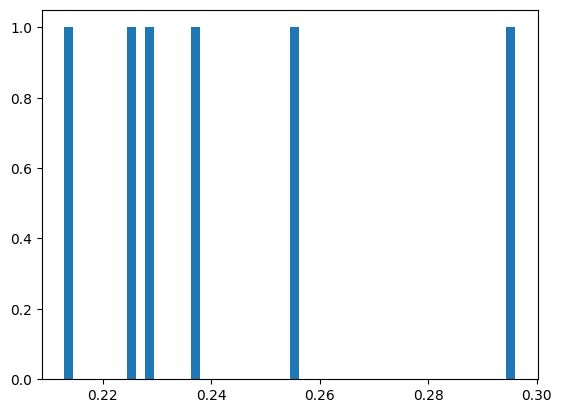

In [34]:
dice_coefs = list()
for i in tqdm(range(len(img_test))):
    prediction_2 = model_2.predict(img_test[i].reshape(1,img_side_size,256,1))
    dice = dice_coef_test(y_true = mask_test[i], y_pred = prediction_2)
    dice_coefs.append(dice)

plt.hist(np.array(dice_coefs), bins = 50)
print(np.median(np.array(dice_coefs)))

# 5. Инференс модели (вывод о работе модели на тестовых объектах)

Качество второй модели значительно выше. Медиана дайс-коэффициента равна 0,2329. Модель лучше сегментирует лёгкие за счёт более лучшей архитектуры.

В целом, сравнивая истинную маску с предсказанной, видно, что на некторых объектах модель предсказывает сегментацию очень хорошо, а на некторых весьма приблизительно.

# 6. Выводы по работе (интерпретация результатов, что можно ещё поделать, чего не хватило, планы на будущее)

Очевидно, что архитектура сети имеет решающее значение для качества сегментации. Поэтому наибольший пророст качества можно получить, использую наиболее подходящую архитектуру сети.

Ипользование предобученной сети поможет обучить модель быстрее и лучше.

Также не стоит упускать важность настройки других гиперпараметров, а именно:

* можно повысить качество, увеличив количество эпох обучения
* можно найти оптимальный размер батча
* возможно стоит подобрать параметр patience для early_stopping

Используя комбинацию вышеуказанных параметров можно дополнительно настроить модель и улучшить её работу.